<h1>ML-7. Практика</h1>

<h3>Импорт необходимых библиотек</h3>

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

C:\Users\inomistov\AppData\Local\Temp\ipykernel_17484\2150022218.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<h3>Описание задачи</h3>

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).
<ul>Данные представлены в формате CSV.  Каждая строка представляет молекулу. 
<li>Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1];</li>
<li>Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.</li>
</ul>
<p>Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.</p>

<h3>Знакомство с данными</h3>

In [2]:
data = pd.read_csv('data/_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Предобработка данных не требуется

Смотрим на сбалансированность классов:

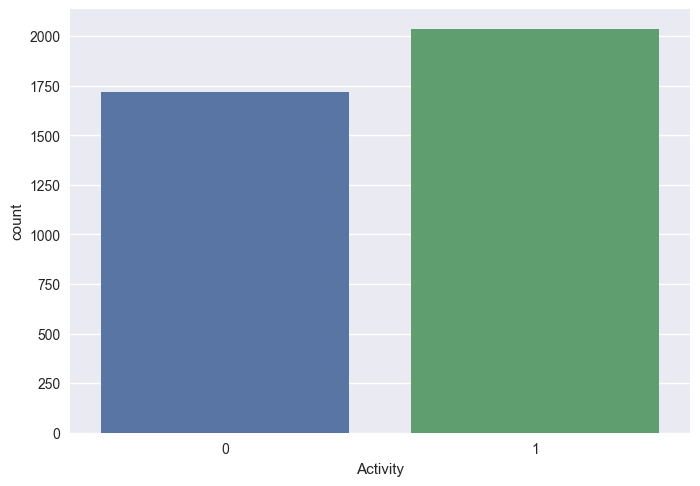

In [3]:
sns.countplot(data=data, x='Activity');

Данные сбалансированы

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [4]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

<h3>Оптимизация гиперпараметров модели</h3>

<ul>По условию задачи требуется использовать все четыре метода оптимизации хотя бы один раз:
<li>GridSeachCV,</li>
<li>RandomizedSearchCV,</li>
<li>Hyperopt,</li>
<li>Optuna</li>
</ul>

<h3>Логистическая регрессия</h3>

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [6]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 50)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 0.87
f1_score на тестовом наборе: 0.79


c:\python\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<h4>GridSearchCV</h4>

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
y_train_pred = grid_search.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 2.55 s
Wall time: 9.9 s
f1_score на тренировочном наборе: 0.86
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'saga'}


c:\python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Значения метрик ухудшились как на тренировочном, так и тестовом наборах, что должно означать, что мы не нашли комбинацию внешних параметров лучше, чем заданы по умолчанию.

Расширим сетку гиперпараметров.

In [8]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train, y_train) 
y_train_pred = grid_search_1.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 1.61 s
Wall time: 1min 50s
f1_score на тренировочном наборе: 0.85
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


c:\python\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Результат получился разнонаправленный: метрика для тренировочной выборки еще уменьшилась, зато метрика на тестовой вернулась к первоначальному значению. Опять можно сказать, что нам не удалось найти комбинацию анешних параметров лучше, чем заданные по умолчанию.

Итоговые полученные модели 

In [9]:
print("Наилучшая модель с двумя параметрами:\n{}".format(grid_search.best_estimator_))
print("Наилучшая модель с расширенным набором параметров:\n{}".format(grid_search_1.best_estimator_))

Наилучшая модель с двумя параметрами:
LogisticRegression(max_iter=50, random_state=42, solver='saga')
Наилучшая модель с расширенным набором параметров:
LogisticRegression(C=0.1, max_iter=50, random_state=42)


In [10]:
print("Наилучшее значение точности при кросс-валидации для двух параметров: {:.2f}".format(grid_search.best_score_))
print("Наилучшее значение точности при кросс-валидации с расширенным набором параметров: {:.2f}".format(grid_search_1.best_score_))

Наилучшее значение точности при кросс-валидации для двух параметров: 0.76
Наилучшее значение точности при кросс-валидации с расширенным набором параметров: 0.76


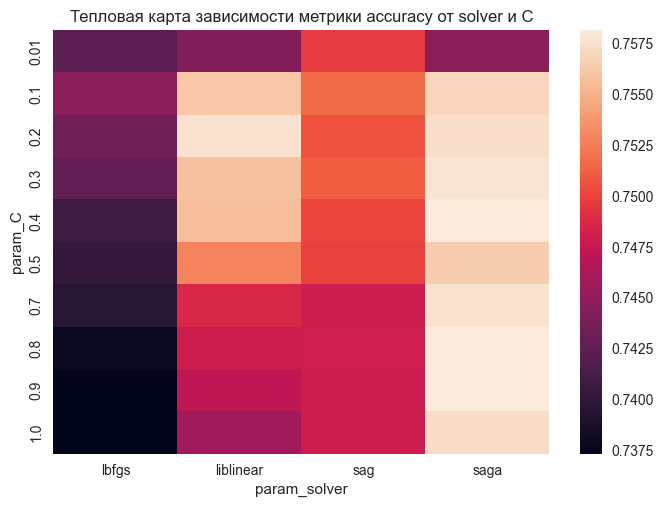

In [11]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Видим, что слабая регуляризация С = 0,01 отрицательно влияет на метрику, поэтому можно было использовать C>0.01, лучшим алгоритмом оптимизации является saga.

<h4>RandomizedSearchCV</h4>

In [12]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {'penalty': ['l2', 'none'],
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train)

y_train_pred = random_search.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print('Наилучшие значения гиперпараметров: {}'.format(random_search.best_params_))

CPU times: total: 2.33 s
Wall time: 17.3 s
f1_score на тренировочном наборе: 0.86
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.23}


c:\python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Результат для тестовой выборки получился аналогичен, а метрика на тренировочной выборке выросла по отношению GridSearchCV.

Попробуем улучшить результат, взяв расширенный набор параметров.

In [13]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
]

random_search_1 = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_1.fit(X_train, y_train)

y_train_pred = random_search_1.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

# print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
# y_test_pred = random_search.predict(X_test)
# print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(random_search_1.best_params_))

CPU times: total: 2.27 s
Wall time: 15.9 s
f1_score на тренировочном наборе: 0.87
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.89}


c:\python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


При расширенном наборе параметров значение метрики на тестовой выборке выросло.

In [14]:
print("Наилучшее значение точности при кросс-валидации для двух параметров: {:.2f}".format(random_search.best_score_))
print("Наилучшее значение точности при кросс-валидации с расширенным набором параметров: {:.2f}".format(random_search_1.best_score_))

Наилучшее значение точности при кросс-валидации для двух параметров: 0.76
Наилучшее значение точности при кросс-валидации с расширенным набором параметров: 0.75


<h3>Случайный лес</h3>

По условию задачи нам предстоит теперь рассмотреть модель случайного леса, использовав матоды оптимизации.
GridSearchCV и  RandomizedSearchCV мы уже использовали, но и для данной модели мы не будем убирать их из рассмотрения. Hyperopt и Optuna нами еще не использовались, поэтому они будут рассмотрены в обязательном порядке.

<h4>GridSearchCV</h4>

In [15]:
#from sklearn.model_selection import GridSearchCV

space={'n_estimators': list(np.linspace(100, 300, 10, dtype=int)), # количество деревьев в лесу
       'max_depth' : list(np.linspace(15, 40, 5, dtype=int)), # глубина дерева
       'min_samples_leaf': list(np.linspace(3, 7, 3, dtype=int))
      }
grid_search_rf = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(
        random_state=42, #генератор случайных чисел
    ), 
    param_grid=space, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_rf.fit(X_train, y_train) 
y_train_pred = grid_search_rf.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search_rf.best_params_))

CPU times: total: 6.47 s
Wall time: 7min 7s
f1_score на тренировочном наборе: 0.98
Test: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 27, 'min_samples_leaf': 3, 'n_estimators': 277}


Модель случайного леса с использованием GridSearchCV показала очень достойный результат. Получившиеся метрики на тренировочной и тестовой выборках превосходят аналогичные для логистической регрессии.

<h4>RandomizedSearchCV</h4>

In [16]:
random_search_rf = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=space, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_rf.fit(X_train, y_train)

y_train_pred = random_search_rf.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print('Наилучшие значения гиперпараметров: {}'.format(random_search.best_params_))

CPU times: total: 4.61 s
Wall time: 37 s
f1_score на тренировочном наборе: 0.98
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.23}


Модель случайного леса с использованием RandomizedSearchCV показала результаты ниже на тренировочном наборе и такие же на тестовом по отношению к GridSearchCV. Значительным плюсом данного подхода стало время выполнения.

Далее рассмотрим методы продвинутой оптимизации.

<h4>Hyperopt</h4>

In [17]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


In [18]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 150, 250, 10),
       'max_depth' : hp.quniform('max_depth', 15, 30, 4),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 7, 1)
      }

In [19]:
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
 
#    score = metrics.f1_score(y, model.predict(X))
    
    # применим  cross validation с количеством фолдов cv
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [20]:
# начинаем подбор гиперпараметров
#%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print('Наилучшие значения гиперпараметров {}'.format(best))


100%|██████████| 20/20 [01:59<00:00,  5.96s/trial, best loss: -0.8115769829091357]
Наилучшие значения гиперпараметров {'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 190.0}


In [21]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)



model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 0.99
f1_score на тестовом наборе: 0.83


Использование продвинутой оптимизации Hyperopt для модели случайного леса позволило улучшить результаты обоих наборов. Для обучения модели использовалась кросс-валидация.

Попробуем добиться нахождения более оптимальных парамертов, увеличив количество итераций.

In [22]:
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) 
# и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=30, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print('Наилучшие значения гиперпараметров {}'.format(best))

100%|██████████| 30/30 [01:12<00:00,  7.23s/trial, best loss: -0.8126295404033579]
Наилучшие значения гиперпараметров {'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 200.0}


In [23]:
# рассчитаем точность для тестовой выборки
model_30 = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)



model_30.fit(X_train, y_train)
y_train_pred = model_30.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model_30.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 0.99
f1_score на тестовом наборе: 0.82


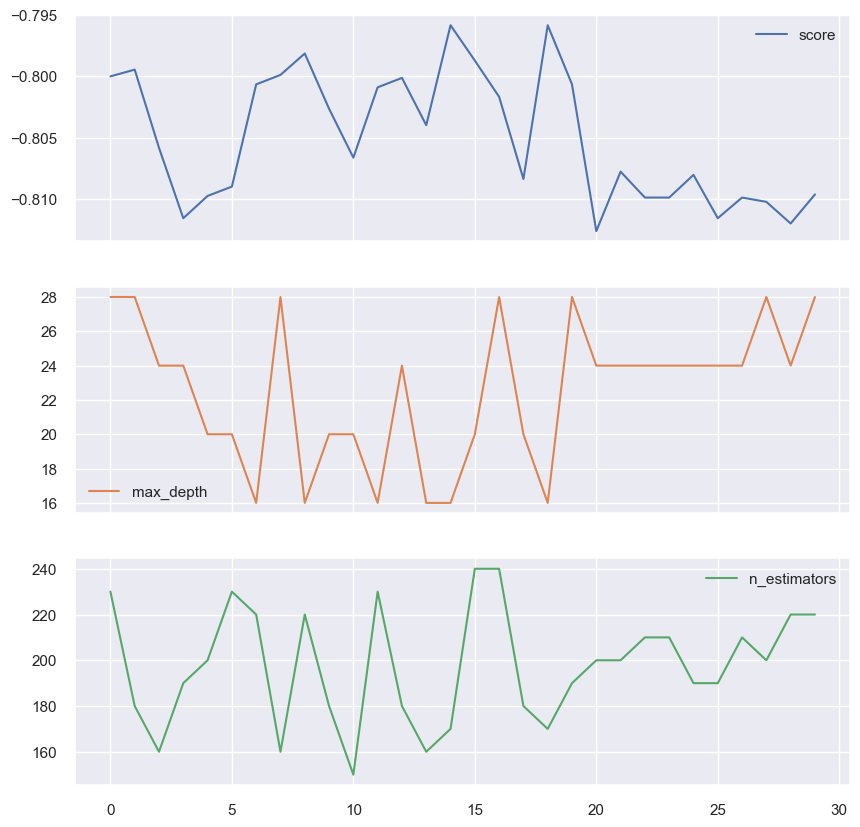

In [24]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

По графикам видно, что лучшая точность достигается именно в best_params.

<h4>Optuna</h4>

In [25]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.1.1


c:\python\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [27]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)

[I 2023-06-28 14:33:27,370] A new study created in memory with name: RandomForestClassifier
[I 2023-06-28 14:33:31,984] Trial 0 finished with value: 0.978267523722069 and parameters: {'n_estimators': 270, 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.978267523722069.
[I 2023-06-28 14:33:34,279] Trial 1 finished with value: 0.9281565270559463 and parameters: {'n_estimators': 160, 'max_depth': 31, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.978267523722069.
[I 2023-06-28 14:33:37,271] Trial 2 finished with value: 0.9258468111077205 and parameters: {'n_estimators': 210, 'max_depth': 32, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.978267523722069.
[I 2023-06-28 14:33:39,029] Trial 3 finished with value: 0.9435803598658127 and parameters: {'n_estimators': 110, 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.978267523722069.
[I 2023-06-28 14:33:43,706] Trial 4 finished with value: 0.959339651482727 and parameters: {'n_estima

CPU times: total: 1min 54s
Wall time: 1min 55s


In [28]:
# выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров {}'.format(study.best_params))
print('f1_score на тренировочном наборе: {:.2f}'.format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 300, 'max_depth': 23, 'min_samples_leaf': 3}
f1_score на тренировочном наборе: 0.98


In [29]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82


Видим, что использование Optuna не привело к увеличению метрики.

Рассмотрим различные визуализации, доступные через Optuna, которые помогают принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.

Сначало необходимо проверить, доступна ли поддержка визуализации: is_available (), т.е. доступны ли правильные версии plotly и matplotlib для создания визуализаций.

In [30]:
optuna.visualization.is_available()

True

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [31]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

В нашем случае, все идет верно, метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [32]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_sampeles_leaf

График контура отношений гиперпараметров

Он показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [33]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

Точки с белым фоном это и есть лучшии комбинации n_estimator, max_depth.














